## Preliminary Steps

In [58]:
import numpy as np
import pandas as pd
from IPython.display import display_html

# Modeling / metrics
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from xgboost import XGBClassifier

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility across cells
RANDOM_STATE = 42

In [59]:
df = pd.read_csv("sales_and_customer_insights.csv")
df

,Customer_ID,Product_ID,Transaction_ID,Purchase_Frequency,Average_Order_Value,Most_Frequent_Category,Time_Between_Purchases,Region,Churn_Probability,Lifetime_Value,Launch_Date,Peak_Sales_Date,Season,Preferred_Purchase_Times,Retention_Strategy
0,CUST_9HOS83,PROD_IK97D1,TRANS_II1DZG,17,172.57,Electronics,45,South America,0.98,952.81,2020-03-14,2023-09-11,Winter,Afternoon,Loyalty Program
1,CUST_AJU17N,PROD_UNN7KP,TRANS_9HJF7I,10,64.89,Clothing,6,South America,0.66,5427.51,2022-10-15,2023-01-02,Spring,Afternoon,Discount
2,CUST_11XNYF,PROD_0XEW2W,TRANS_OT96OM,3,120.38,Sports,23,Asia,0.60,3994.80,2021-11-30,2023-04-06,Winter,Evening,Loyalty Program
3,CUST_IGH8G3,PROD_3IIAJN,TRANS_45V00G,12,70.34,Clothing,5,North America,0.78,4880.01,2022-03-20,2023-03-23,Spring,Evening,Discount
4,CUST_OK6PUM,PROD_VMIWD2,TRANS_ZAK760,18,42.39,Electronics,10,North America,0.52,8557.70,2022-11-09,2023-10-28,Spring,Morning,Discount
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,CUST_BIH0QW,PROD_AAPCHD,TRANS_EP2EGL,15,162.51,Clothing,72,Europe,0.84,1154.61,2022-03-04,2023-02-10,Winter,Evening,Loyalty Program
9996,CUST_DWJAD2,PROD_XWJQE5,TRANS_X7OPB7,18,63.02,Clothing,68,Europe,0.03,593.22,2021-08-21,2023-02-06,Spring,Morning,Loyalty Program
9997,CUST_43HBYL,PROD_PL3BU5,TRANS_VSZM3Y,15,116.80,Home,72,Asia,0.61,4676.35,2020-09-13,2023-05-05,Spring,Evening,Discount
9998,CUST_0SX4MD,PROD_X5O49V,TRANS_B2YCHY,12,144.21,Electronics,38,North America,0.05,6850.85,2020-01-26,2023-08-03,Summer,Morning,Discount


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               10000 non-null  object 
 1   Product_ID                10000 non-null  object 
 2   Transaction_ID            10000 non-null  object 
 3   Purchase_Frequency        10000 non-null  int64  
 4   Average_Order_Value       10000 non-null  float64
 5   Most_Frequent_Category    10000 non-null  object 
 6   Time_Between_Purchases    10000 non-null  int64  
 7   Region                    10000 non-null  object 
 8   Churn_Probability         10000 non-null  float64
 9   Lifetime_Value            10000 non-null  float64
 10  Launch_Date               10000 non-null  object 
 11  Peak_Sales_Date           10000 non-null  object 
 12  Season                    10000 non-null  object 
 13  Preferred_Purchase_Times  10000 non-null  object 
 14  Retenti

In [61]:
df.drop(['Customer_ID', 'Product_ID', 'Transaction_ID', 'Launch_Date', 'Peak_Sales_Date'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Purchase_Frequency        10000 non-null  int64  
 1   Average_Order_Value       10000 non-null  float64
 2   Most_Frequent_Category    10000 non-null  object 
 3   Time_Between_Purchases    10000 non-null  int64  
 4   Region                    10000 non-null  object 
 5   Churn_Probability         10000 non-null  float64
 6   Lifetime_Value            10000 non-null  float64
 7   Season                    10000 non-null  object 
 8   Preferred_Purchase_Times  10000 non-null  object 
 9   Retention_Strategy        10000 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 781.4+ KB


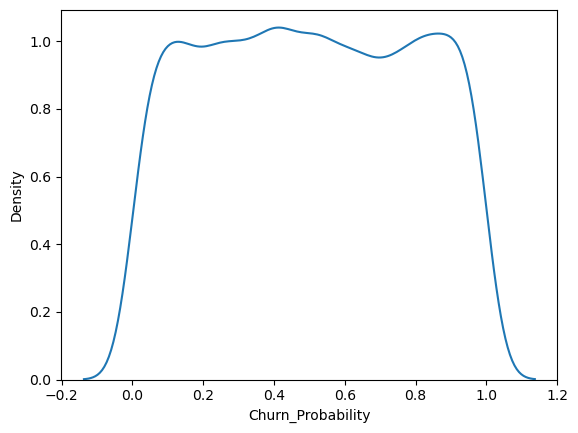

In [62]:
sns.kdeplot(df['Churn_Probability']);

The objective of this project is to build a model to determine customer churn rate based on the given customer attributes. The metric to measure model performance that I will be using is AUC (area under the curve), a popular success metric in classification models. With this in mind, the objective of the model is to achieve a high AUC between both the training and test data. 

The model I chose to use was an XGBoost model since it's generally the most thorough and applicable. In my case, it takes precedent over other forms of models like LightGBM and CATBoost since there isn't a large amount of data and XGBoost can now handle categorical variables natively. I also decided to drop categories related to date or customer identification since that won't contribute to my dataset. The code chunk 2 blocks above this reflects the number of columns that I will use moving forward.

## XGBoost Model

### Preparing features/labels

In [63]:
#1 turning to binary churn
y = (df["Churn_Probability"] >= 0.50).astype(int)

In [64]:
#2 make x without the target variable
X = df.copy(deep=True)
X = X.drop("Churn_Probability", axis=1)

In [65]:
#3 train / test split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

# test / val split
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)

print("Train:", X_train.shape, " Valid:", X_valid.shape, " Test:", X_test.shape)
X_train.head()

Train: (7000, 9)  Valid: (1500, 9)  Test: (1500, 9)


,Purchase_Frequency,Average_Order_Value,Most_Frequent_Category,Time_Between_Purchases,Region,Lifetime_Value,Season,Preferred_Purchase_Times,Retention_Strategy
3827,6,168.79,Home,33,Asia,8434.77,Fall,Afternoon,Email Campaign
7329,14,63.66,Electronics,65,South America,2518.81,Summer,Morning,Email Campaign
1992,9,199.08,Clothing,51,Asia,1306.81,Fall,Afternoon,Email Campaign
6495,1,129.83,Sports,74,North America,1337.70,Fall,Morning,Email Campaign
9260,5,90.75,Electronics,53,South America,1809.76,Fall,Morning,Loyalty Program


In [66]:
#4 convert object columns to category (usable for xgboost)
obj_cols = X_train.select_dtypes(include=["object"]).columns
for c in obj_cols:
    X_train[c] = X_train[c].astype("category")
    X_valid[c] = X_valid[c].astype("category")
    X_test[c] = X_test[c].astype("category")

#same process as before where converting to usable container for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)


In [67]:
# Cell 5 — Baseline model with native categorical support + early stopping
# Training parameters (same as before)
params_train = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",

    # tree structure
    "max_depth": 3,
    "min_child_weight": 3.0,
    "gamma": 0.0,

    # sampling
    "subsample": 0.85,
    "colsample_bytree": 0.85,

    # regularization
    "reg_lambda": 1.0,
    "reg_alpha": 0.0,

    # learning
    "learning_rate": 0.125,
}

num_boost_round = 750
early_stopping_rounds = 50
evals = [(dtrain, "train"), (dvalid, "valid")]

# Train model with early stopping
#Trains up to 750 rounds and stops if AUC doesn't incrase for 50 consecutive rounds
booster = xgb.train(
    params=params_train,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=False,
)

# Save best iteration info
best_iter = booster.best_iteration
num_trees = best_iter + 1  # XGBoost counts from 0
print(f"Best iteration: {best_iter}  |  Trees used for prediction: {num_trees}")


Best iteration: 3  |  Trees used for prediction: 4


In [68]:
# Cell 6 — Evaluate train/validation AUC at best iteration
# Predict using only trees up to the best iteration

#these lines produce predicted churn probs for each observation
p_train = booster.predict(dtrain, iteration_range=(0, num_trees))
p_valid = booster.predict(dvalid, iteration_range=(0, num_trees))

#computes AUC on both sets
auc_train = roc_auc_score(y_train, p_train)
auc_valid = roc_auc_score(y_valid, p_valid)

#prints results
print(f"Train AUC @ best: {auc_train:.6f}")
print(f"Valid AUC @ best: {auc_valid:.6f}")


Train AUC @ best: 0.562376
Valid AUC @ best: 0.512292


In [69]:
#7 Ranks feature importances based on gain
# Extract gain-based importance scores from the booster
gain_scores = booster.get_score(importance_type="gain")

# converts list to df for easier viewing
imp_df = (
    pd.DataFrame(
        list(gain_scores.items()), columns=["Feature", "Gain"]
    )
    .sort_values("Gain", ascending=False)
    .reset_index(drop=True)
)

if imp_df.empty:
    print("No feature importances found.")
    ordered_feats = []
else:
    # Display top features numerically
    print("Top Features by Gain")
    display(imp_df.head(25))


Top Features by Gain


,Feature,Gain
0,Region,4.857800
1,Retention_Strategy,4.416616
2,Most_Frequent_Category,4.399785
3,Lifetime_Value,4.299043
4,Average_Order_Value,4.287814
5,Season,4.184881
6,Preferred_Purchase_Times,4.116283
7,Purchase_Frequency,4.074553
8,Time_Between_Purchases,3.658886


Chosen K (kept): 3
Kept features (top of list): ['Region', 'Retention_Strategy', 'Most_Frequent_Category'] 


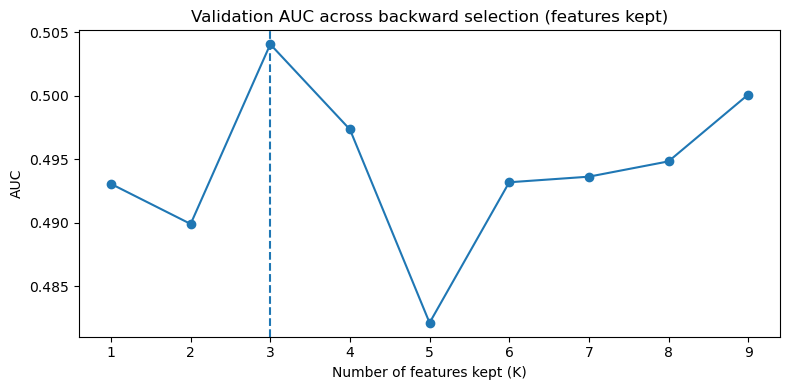

In [70]:
# Cell 8a — backward selection driven by imp_df (gain ranking)

# 1) Build the ordered feature list (most → least important)
if "imp_df" not in globals() or imp_df is None or imp_df.empty:
    print("No importances available; falling back to column order.")
    ordered_feats = X_train.columns.tolist()
else:
    ordered_feats = imp_df["Feature"].tolist()  # assume already sorted desc by importance

# Safety: ensure no missing columns crept in
ordered_feats = [f for f in ordered_feats if f in X_train.columns]
if not ordered_feats:
    raise ValueError("No valid features found for selection.")

# 2) Backward sweep: start with ALL features, remove the least-important one each step
results = []
feats_current = ordered_feats.copy()  # start full set (K = all)

while True:
    # DMatrix for current feature set
    dtr_k = xgb.DMatrix(X_train[feats_current], label=y_train, enable_categorical=True)
    dva_k = xgb.DMatrix(X_valid[feats_current], label=y_valid, enable_categorical=True)

    # Train with fixed number of trees (from Cell 5)
    model_k = xgb.train(
        params=params_train,
        dtrain=dtr_k,
        num_boost_round=num_trees,
        verbose_eval=False,
    )

    # Validation AUC with current kept features
    p_k = model_k.predict(dva_k, iteration_range=(0, num_trees))
    auc_k = roc_auc_score(y_valid, p_k)
    results.append((len(feats_current), auc_k))

    # Stop if only one feature left; otherwise drop the current least-important feature
    if len(feats_current) == 1:
        break
    # Remove least-important = last element in ordered list
    feats_current = feats_current[:-1]

# 3) Results dataframe: K (features kept) vs val AUC
df_k = pd.DataFrame(results, columns=["k_kept", "val_auc"]).sort_values("k_kept").reset_index(drop=True)

# 4) Select the global max
chosen_k = int(df_k.loc[df_k["val_auc"].idxmax(), "k_kept"])

# 5) Final kept feature list = top 'chosen_k' from ordered_feats
# (since backward dropped from the tail, the best subset is still the prefix)
topK_features = ordered_feats[:chosen_k]

print(f"Chosen K (kept): {chosen_k}")
preview = topK_features[:20]
print("Kept features (top of list):", preview, f"... (+{len(topK_features)-len(preview)} more)" if len(topK_features) > len(preview) else "")

# 6) Visualize K kept vs AUC (backward elimination curve)
plt.figure(figsize=(8,4))
plt.plot(df_k["k_kept"], df_k["val_auc"], marker="o")
plt.axvline(chosen_k, linestyle="--")
plt.title("Validation AUC across backward selection (features kept)")
plt.xlabel("Number of features kept (K)")
plt.ylabel("AUC")
plt.tight_layout()
plt.show()


Chosen K: 3
Top-K features: ['Region', 'Retention_Strategy', 'Most_Frequent_Category'] 


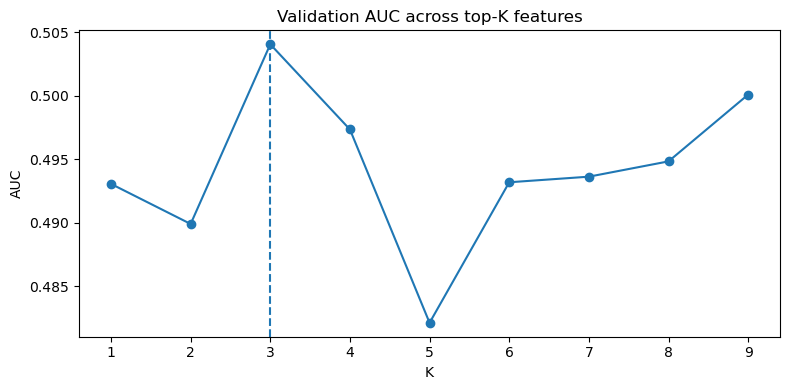

In [71]:
# Cell 8b — forward selection driven by imp_df (gain ranking)

# Build the ordered feature list
if "imp_df" not in globals() or imp_df.empty:
    print("No importances available.")
    ordered_feats = X_train.columns.tolist()
else:
    ordered_feats = imp_df["Feature"].tolist() #actual part that builds the list

# 2) Sweep K with the same params and number of trees found in Cell 5
results = []
max_k = min(len(ordered_feats), X_train.shape[1])

for k in range(1, max_k + 1):
    feats_k = ordered_feats[:k]

    #makes Dmatricies for k features
    dtr_k = xgb.DMatrix(X_train[feats_k], label=y_train, enable_categorical=True)
    dva_k = xgb.DMatrix(X_valid[feats_k], label=y_valid, enable_categorical=True)

    # Train with fixed number of trees
    model_k = xgb.train(
        params=params_train,
        dtrain=dtr_k,
        num_boost_round=num_trees,
        verbose_eval=False,
    )

    #predicts probability then computes validation auc for that subset
    p_k = model_k.predict(dva_k, iteration_range=(0, num_trees))
    auc_k = roc_auc_score(y_valid, p_k)
    results.append((k, auc_k))

df_k = pd.DataFrame(results, columns=["k", "val_auc"])

# selects global max
chosen_k = int(df_k.loc[df_k["val_auc"].idxmax(), "k"])

#build final feature list
topK_features = ordered_feats[:chosen_k]
print(f"Chosen K: {chosen_k}")
print("Top-K features:", topK_features[:20], f"... (+{len(topK_features)-20} more)" if len(topK_features) > 20 else "")

# Visualize K vs AUC
plt.figure(figsize=(8,4))
plt.plot(df_k["k"], df_k["val_auc"], marker="o")
plt.axvline(chosen_k, linestyle="--")
plt.title("Validation AUC across top-K features")
plt.xlabel("K"); plt.ylabel("AUC"); plt.tight_layout()
plt.show()


In [72]:
# Cell 9 — retrain on top-K with early stopping and report AUCs
# DMatrices for top-K features
dtrain_k = xgb.DMatrix(X_train[topK_features], label=y_train, enable_categorical=True)
dvalid_k = xgb.DMatrix(X_valid[topK_features], label=y_valid, enable_categorical=True)

#running model with new selected features ONLY
booster_k = xgb.train(
    params=params_train,
    dtrain=dtrain_k,
    num_boost_round=750,
    evals=[(dtrain_k, "train"), (dvalid_k, "valid")],
    early_stopping_rounds=50,
    verbose_eval=False,
)

#captures best iteration
best_iter_k = booster_k.best_iteration
num_trees_k = best_iter_k + 1

p_train_k = booster_k.predict(dtrain_k, iteration_range=(0, num_trees_k))
p_valid_k = booster_k.predict(dvalid_k, iteration_range=(0, num_trees_k))

#computes aucs
auc_train_k = roc_auc_score(y_train, p_train_k)
auc_valid_k = roc_auc_score(y_valid, p_valid_k)

print(f"[Top-K] Best iteration: {best_iter_k}  |  Trees used: {num_trees_k}")
print(f"[Top-K] Train AUC: {auc_train_k:.6f}")
print(f"[Top-K] Valid AUC: {auc_valid_k:.6f}")


[Top-K] Best iteration: 2  |  Trees used: 3
[Top-K] Train AUC: 0.534965
[Top-K] Valid AUC: 0.506504


In [73]:
# Cell 10 — rank-order helper + decile tables for train/valid

#helper function
def rank_order_df(y_true, y_prob, bins=10):
    df_tmp = pd.DataFrame({"y": pd.Series(y_true).values, "p": pd.Series(y_prob).values})
    # Highest probability -> Decile 1
    df_tmp["decile"] = pd.qcut(-df_tmp["p"], q=bins, duplicates="drop").cat.codes + 1

    #group by decile and compute metrics
    grp = df_tmp.groupby("decile", as_index=False).agg(
        n=("y", "size"),
        avg_actual=("y", "mean"),
        avg_pred=("p", "mean"),
        positives=("y", "sum"),
    )
    #computes lift
    overall_rate = df_tmp["y"].mean()
    grp["lift"] = grp["avg_actual"] / overall_rate
    return grp.sort_values("decile")

# Build DMatrices once (already have dtrain_k, dvalid_k above)
# Use predictions from Cell 9:
ro_train_10 = rank_order_df(y_train, p_train_k, bins=10)
ro_valid_10 = rank_order_df(y_valid, p_valid_k, bins=10)

print("=== Rank Order: TRAIN (10 deciles) ===")
display(ro_train_10[["decile","n","avg_actual","avg_pred","lift"]])

print("\n=== Rank Order: VALIDATION (10 deciles) ===")
display(ro_valid_10[["decile","n","avg_actual","avg_pred","lift"]])


=== Rank Order: TRAIN (10 deciles) ===


,decile,n,avg_actual,avg_pred,lift
0,1,738,0.552846,0.516995,1.097227
1,2,715,0.525874,0.512309,1.043697
2,3,757,0.557464,0.509471,1.106392
3,4,682,0.510264,0.507377,1.012715
4,5,720,0.502778,0.504215,0.997858
5,6,695,0.476259,0.502859,0.945226
6,7,613,0.497553,0.500856,0.987488
7,8,729,0.477366,0.498356,0.947424
8,9,752,0.468085,0.494926,0.929004
9,10,599,0.459098,0.491895,0.911168



=== Rank Order: VALIDATION (10 deciles) ===


,decile,n,avg_actual,avg_pred,lift
0,1,175,0.542857,0.516886,1.077098
1,2,147,0.503401,0.512382,0.998812
2,3,141,0.439716,0.509512,0.872453
3,4,158,0.512658,0.507573,1.017179
4,5,140,0.492857,0.504217,0.977891
5,6,159,0.484277,0.503403,0.960867
6,7,139,0.625899,0.501046,1.241864
7,8,146,0.465753,0.499136,0.924114
8,9,176,0.500000,0.495014,0.992063
9,10,119,0.462185,0.491910,0.917033


In [77]:
# Cell 11 — Manual hyperparameter tuning (iterative sweep)

# Base parameters (from earlier cells)
base_params = params_train.copy()

# Example manual grid of values to test
param_grid = [
    {#baseline
    "max_depth": 3, "min_child_weight": 3.0, "gamma": 0.0,
    "subsample": 0.85, "colsample_bytree": 0.85,
    "reg_lambda": 1.0, "reg_alpha": 0.0,
    "learning_rate": 0.125,},

    #change colsample_bytree to 1.0
    {"max_depth": 3, "min_child_weight": 3.0, "gamma": 0.0,
    "subsample": 0.85, "colsample_bytree": 1.0,
    "reg_lambda": 1.0, "reg_alpha": 0.0,
    "learning_rate": 0.125,},

    #change max depth to 4
    {"max_depth": 4, "min_child_weight": 3.0, "gamma": 0.0,
    "subsample": 0.85, "colsample_bytree": 0.85,
    "reg_lambda": 0.25, "reg_alpha": 0.0,
    "learning_rate": 0.125,},

    #change lambda to 0.5
    {"max_depth": 3, "min_child_weight": 3.0, "gamma": 0.0,
    "subsample": 0.85, "colsample_bytree": 0.85,
    "reg_lambda": 0.5, "reg_alpha": 0.0,
    "learning_rate": 0.125,}
]

results = []

for i, update in enumerate(param_grid, start=1):
    # Merge with baseline
    params = base_params.copy()
    params.update(update)
    
    print(f"\n=== Run {i}: {update} ===")

    # Build DMatrices
    dtrain = xgb.DMatrix(X_train[topK_features], label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid[topK_features], label=y_valid, enable_categorical=True)

    # Train model with fixed number of trees (or early stopping if supported)
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=750,
        early_stopping_rounds = 50,
        evals=[(dvalid, "valid")],
        verbose_eval=False
    )

    # Predict + compute AUC
    preds = model.predict(dvalid)
    auc = roc_auc_score(y_valid, preds)
    print(f"AUC: {auc:.4f}")
    results.append((update, auc))

# Create summary DataFrame
df_results = pd.DataFrame([
    {"learning_rate": p["learning_rate"], "max_depth": p["max_depth"],
     "subsample": p["subsample"], "AUC": auc}
    for p, auc in results
]).sort_values("AUC", ascending=False).reset_index(drop=True)

display(df_results)



=== Run 1: {'max_depth': 3, 'min_child_weight': 3.0, 'gamma': 0.0, 'subsample': 0.85, 'colsample_bytree': 0.85, 'reg_lambda': 1.0, 'reg_alpha': 0.0, 'learning_rate': 0.125} ===
AUC: 0.4917

=== Run 2: {'max_depth': 3, 'min_child_weight': 3.0, 'gamma': 0.0, 'subsample': 0.85, 'colsample_bytree': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.0, 'learning_rate': 0.125} ===
AUC: 0.4852

=== Run 3: {'max_depth': 4, 'min_child_weight': 3.0, 'gamma': 0.0, 'subsample': 0.85, 'colsample_bytree': 0.85, 'reg_lambda': 0.25, 'reg_alpha': 0.0, 'learning_rate': 0.125} ===
AUC: 0.4931

=== Run 4: {'max_depth': 3, 'min_child_weight': 3.0, 'gamma': 0.0, 'subsample': 0.85, 'colsample_bytree': 0.85, 'reg_lambda': 0.5, 'reg_alpha': 0.0, 'learning_rate': 0.125} ===
AUC: 0.4911


,learning_rate,max_depth,subsample,AUC
0,0.125,4,0.85,0.493081
1,0.125,3,0.85,0.491687
2,0.125,3,0.85,0.491115
3,0.125,3,0.85,0.485235


The XGBoost model, and the various iterations of it are shown within this chunk of code blocks. To start this process, I first split the data into training, testing, and validation. After I had my training and validation splits for the preliminary models, I began my feature selection process. The objective of this was to eliminate any variables that simply introduce noise and don't provide much predictive power to my model. The optimal number of variables the was 3 variables, as proven by both forward and backward feature selection. This raised one area of concern as this reduced the number of columns even further. Regardless, I decided to move forward with 3 variables. 

With the proper number of features now selected, I ran a preliminary model evaluating the performance of those 3 variables. The validation AUC that I got was .506504 with training AUC of 0.534965. Based on these preliminary results, the model is performing at about a random chance right now which is not ideal. I also created decile bins to examine rank ordering among my results, and found that these results also weren't ideal. This led to me think that there would have to be a lot of hyperparameter fine tuning since the AUC was so low. 

To combat this low AUC as provided by the initial model, I decided to tweak the learning hyperparameters and the penalization parameters. The goal of these actions were to increase the AUC by allowing for deeper learning. However, when I changed these parameters from my intial hyperparameter metrics, I got even lower AUC results. This led me to think there was an issue with the data and if there was a strong predictive ability with my dataset. To further investigate that notion, I created the random forest model to see if there was an issue with XGBoost's modeling. 

## Random Forest Model

In [88]:
# RF 1 — imports & checks
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

#checks to make sure that topK_features isn't empty and every feature name in topK actually exists
assert "topK_features" in globals() and len(topK_features) > 0, "Missing topK_features from your selection step."
assert set(topK_features).issubset(X_train.columns), "Some topK_features not found in X_train."


In [92]:
#RF 2 - One hot encoding

# Work only with your selected features
Xtr_sel = X_train[topK_features].copy()
Xva_sel = X_valid[topK_features].copy()

# Identify categorical vs numeric columns
cat_cols = Xtr_sel.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in Xtr_sel.columns if c not in cat_cols]

# --- Handle sklearn version differences ---
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False, dtype=np.float32)

# Build transformer: OneHot for cats, passthrough for nums
preproc_ohe = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# Fit on TRAIN only; transform TRAIN and VALID
X_train_rf = preproc_ohe.fit_transform(Xtr_sel)
X_valid_rf = preproc_ohe.transform(Xva_sel)

# Expanded feature names (each category becomes its own column)
rf_features = preproc_ohe.get_feature_names_out().tolist()

print(f"Encoded RF shapes — train: {X_train_rf.shape}, valid: {X_valid_rf.shape}")
print(f"Categorical one-hot encoded: {len(cat_cols)} | Numeric passthrough: {len(num_cols)}")


Encoded RF shapes — train: (7000, 11), valid: (1500, 11)
Categorical one-hot encoded: 3 | Numeric passthrough: 0


In [93]:
# RF-Cell 3 — training (Ordinal-encoded inputs)

from sklearn.ensemble import RandomForestClassifier

# If you already defined rf_params_baseline earlier, this will use it.
# Otherwise, here's a safe fallback:
if "rf_params_baseline" not in globals():
    RF_RANDOM_STATE = 42
    rf_params_baseline = {
        "n_estimators": 500,
        "max_depth": None,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "max_features": "sqrt",
        "bootstrap": True,
        "class_weight": None,   # consider "balanced" if your target is skewed
        "n_jobs": -1,
        "random_state": RF_RANDOM_STATE,
        "oob_score": True
    }

rf = RandomForestClassifier(**rf_params_baseline)
rf.fit(X_train_rf, y_train)

print("OOB score (if enabled):", getattr(rf, "oob_score_", "N/A"))

#OOB score is how well the forest predicts unseen data (conceptually very similar to AUC)

OOB score (if enabled): 0.516


In [94]:
# RF 4 — AUC on train and validation (Ordinal-encoded inputs)

from sklearn.metrics import roc_auc_score

p_train = rf.predict_proba(X_train_rf)[:, 1]
p_valid = rf.predict_proba(X_valid_rf)[:, 1]

train_auc = roc_auc_score(y_train, p_train)
valid_auc = roc_auc_score(y_valid, p_valid)

print(f"Train AUC: {train_auc:.4f}")
print(f"Valid AUC: {valid_auc:.4f}")


Train AUC: 0.5523
Valid AUC: 0.4806


After creating the random forest model, this further confirmed my suspicions that the data has no predictive power. The validation AUC of the random forest model was lower than 50%, suggesting that the model is intentionally trying to learn the wrong answer, or worse than random chance. Through the various models and low AUCs, I concluded that the variables do not contain enough predictive power to create an accurate model. A big takeaway that I learned from this project was that predictions and insights cannot be created from nothing. If there is no signal the model can learn from, then it simply does not exist and goes back to how the data is collected and measured. 